In [22]:
import pandas as pd
import numpy as np
from bert_score import score
import torch
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from evaluate import load

bertscore = load("bertscore")

In [ ]:
sns.set(rc={"figure.figsize": (14, 12)})

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Возьмем данные с уже посчитанным статистиками. Может, нужно будет сравнить полученный скор с количственными данными из EDA.

In [4]:
df = pd.read_csv("./data/text_sum_prods_locs.csv")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26921 entries, 0 to 26920
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   text                26921 non-null  object
 1   raw_product         25730 non-null  object
 2   product             14400 non-null  object
 3   raw_locations       26921 non-null  object
 4   locations           26921 non-null  object
 5   news_date           26921 non-null  int64 
 6   url                 26921 non-null  object
 7   summary             26921 non-null  object
 8   lang                26921 non-null  object
 9   text_words          26921 non-null  object
 10  summary_words       26921 non-null  object
 11  text_lemmas         26921 non-null  object
 12  summary_lemmas      26921 non-null  object
 13  product_lemmas      26921 non-null  object
 14  country_lemmas      26921 non-null  object
 15  num_summary_sents   26921 non-null  int64 
 16  text_len            26

Посчитаем для саммари метрику BertSCORE

В целом преимущества BertSCORE в том, что эта метрика включает контекстное представление текстов через векторные пространства. Сходство кандидата и референса измеряется через косинусное расстояние, оценку точности и полноты проводится путём сопоставления токенов. Также в метрике возможен учет важности редких слов с возможностью корректировки весов.

Для модели саммаризации преимущества этой метрики:
- использование контекстных векторов (например, от BERT и подобных моделей) позволяет лучше понимать смысл текста, что особенно важно для выявления семантической близости между оригинальным текстом и его кратким содержанием. Это обеспечивает более точную оценку качества саммаризации.
- Косинусное сходство между контекстуальными вложениями позволяет оценить, насколько близко содержание саммари соответствует оригинальному тексту, что дает больше понимания, насколько тексты получились содержательно близкими. Такое понимание традиционные метрики, основанные на перекрытии слов, дать не могут.
- Линейное масштабирование значений метрики может облегчить интерпретацию результатов оценки. Это может способствовать более быстрой и точной корректировке моделей саммаризации.

Для нашей задачи также важным бонусом метрики может быть учет редких слов, которые встречаются в новостных текстах.

In [6]:
precision_scores = []
recall_scores = []
f1_scores = []

In [7]:
for text, summary, lang in tqdm.tqdm(zip(df["text"], df["summary"], df["lang"])):
    # lang_code = "en" if lang == "en" else "ru"
    results = bertscore.compute(
        predictions=[summary],
        references=[text],
        # lang=lang_code,
        model_type="bert-base-multilingual-cased",
        device=device,
    )
    precision_scores.append(results["precision"][0])
    recall_scores.append(results["recall"][0])
    f1_scores.append(results["f1"][0])

26921it [20:57, 21.42it/s]


In [8]:
df["precision_score"] = precision_scores
df["recall_score"] = recall_scores
df["f1_score"] = f1_scores

In [9]:
df.to_csv("./data/prods_locs_with_bert_scores.csv", index=False)

In [10]:
df.sample(5)

,text,raw_product,product,raw_locations,locations,news_date,url,summary,lang,text_words,...,summary_unique_len,prod_num,locs_num,prod_locs_num,raw_locs_num,prod_match,locs_match,precision_score,recall_score,f1_score
22225,The African nation of Chad has one of the worl...,"electricity, energy, fossil fuels, Oil, renewa...",NaN,"Chad, Chad ’ s, French, Morocco, nation, Seneg...","Франция, Чад",2022,https://africatimes.com/2022/06/19/new-solar-p...,French renewable energy company InnoVent is bu...,en,"['the', 'african', 'nation', 'of', 'chad', 'ha...",...,24,6,2,8,8,2,2,0.801993,0.619051,0.698746
8684,"Берлин, 24 сентября, 2023, 11:05 — ИА Регнум. ...","Gepard, IRIS-T, Taurus",Gepard,"Берлин, Германия, Киев, США, Украина","Германия, Украина",2023,https://regnum.ru/news/3835031,Берлин собирается поставить Киеву 50 надводных...,ru,"['берлин', ',', '24', 'сентября', ',', '2023,'...",...,39,3,2,5,5,2,3,0.875819,0.644148,0.742328
25721,Turkey's central bank slashed its key interest...,"basic goods, currency bond, deposits",NaN,"country's, Russian, the country, The country's...",Турция,2022,https://www.cnbc.com/2022/10/20/turkey-slashes...,"On October 20, 2022, the Central Bank of Turke...",en,"['turkey', ""'s"", 'central', 'bank', 'slashed',...",...,36,3,1,4,7,0,2,0.760952,0.610348,0.677380
14783,NEW DELHI: Development of the Chabahar port as...,"aerospace technology, agricultural products,, ...","aerospace technology, agricultural products,, ...","Afghanistan, Armenia, Azerbaijan, Brazil - Rus...","Азербайджан, Армения, Афганистан, Иран, Палест...",2024,https://timesofindia.indiatimes.com/india/deve...,"Development of the Chabahar port as a ""golden ...",en,"['new', 'delhi', ':', 'development', 'of', 'th...",...,68,6,9,15,21,0,7,0.893717,0.733137,0.805502
20611,ЕК одобрила будущую покупку концерном Philip M...,"IQOS, жевательный табак, сигара, сигарета, сиг...",NaN,"американская, Москва, Стокгольм, шведская, Швеция","ЕС, США, Швеция",2022,https://www.interfax.ru/world/869496,Европейская комиссия одобрила планируемое прио...,ru,"['ек', 'одобрила', 'будущую', 'покупку', 'конц...",...,16,8,3,11,5,0,1,0.795258,0.590961,0.678055


BertSCORE позволяет посмотреть 3 оценки: precision, recall, f1

<img src=./R_P_F_Bert.jpg>

Precision BERTScore показывает, насколько точно модель саммаризации передает информацию из исходного текста. Он измеряет, сколько токенов в предложении-кандидате соответствуют токенам в эталонном предложении. Чем выше значение precision BERTScore, тем более точно модель передает информацию.

Recall BERTScore показывает, насколько полно модель саммаризации передает информацию из исходного текста. Он измеряет, сколько токенов в эталонном предложении соответствуют токенам в предложении-кандидате. Чем выше значение recall BERTScore, тем более полно модель передает информацию.

F1 BERTScore является объединением precision и recall BERTScore и показывает общую производительность модели саммаризации. Он учитывает как точность, так и полноту передачи информации из исходного текста. Чем выше значение f1 BERTScore, тем более точно и полно модель передает информацию.


Для нашей задачи важно больше внимания обратить на метрику recall или на F1. Можно подумать про Fβ-меру, где β будет приближаться к 2.



Посмотрим на метрику для нескольких случайных текстов и саммари в корпусе.

In [11]:
samp_ru = df[df["lang"] == "ru"][["text", "summary"]].sample(6, random_state=42)

samp_ru

,text,summary
19794,Индийские компании по производству удобрений н...,Соглашение с канадской компанией Canpotex об и...
22686,Греция закупит у США вооружение против турецки...,Греция закупит у США вооружение против турецки...
8003,"Cummins, Daimler Truck и Paccar создадут СП по...",Поставщик автодвигателей Cummins Inc. и произв...
12206,В Москве состоялось 24-е заседание Межправител...,В Москве состоялось 24-е заседание Межправител...
17338,По данным аналитического агентства MEPS Intern...,\n\nПо данным аналитического агентства MEPS In...
25436,"Брюссель, , 11:14 — REGNUM Несмотря на восемь ...","Несмотря на восемь пакетов санкций, адресные м..."


In [12]:
results_ru = bertscore.compute(
    predictions=samp_ru.summary.values,
    references=samp_ru.text.values[::-1],
    model_type="bert-base-multilingual-cased",
    device=device,
)
results_ru

{'precision': [0.6212712526321411,
  0.6383657455444336,
  0.6244276165962219,
  0.6479750871658325,
  0.6232109069824219,
  0.655181884765625],
 'recall': [0.5568631887435913,
  0.5833838582038879,
  0.5825080871582031,
  0.6470156311988831,
  0.6114280819892883,
  0.5811643004417419],
 'f1': [0.5873066186904907,
  0.6096376776695251,
  0.6027398705482483,
  0.6474949717521667,
  0.6172633171081543,
  0.6159574389457703],
 'hashcode': 'bert-base-multilingual-cased_L9_no-idf_version=0.3.12(hug_trans=4.37.1)'}

In [13]:
np.mean(results_ru["precision"]), np.mean(results_ru["recall"]), np.mean(results_ru["f1"])

(0.6350720822811127, 0.593727191289266, 0.6133999824523926)

In [14]:
samp_en = df[df["lang"] == "en"][["text", "summary"]].sample(6, random_state=42)

In [15]:
results_en = bertscore.compute(
    predictions=samp_en.summary.values,
    references=samp_en.text.values[::-1],
    lang="en",
    model_type="bert-base-multilingual-cased",
    device=device,
)
results_en

{'precision': [0.6776880621910095,
  0.6565109491348267,
  0.674109935760498,
  0.6929532289505005,
  0.6811769604682922,
  0.6441564559936523],
 'recall': [0.5868151187896729,
  0.6071188449859619,
  0.6067104339599609,
  0.5847164392471313,
  0.6085753440856934,
  0.6234582662582397],
 'f1': [0.6289862990379333,
  0.6308495998382568,
  0.6386368274688721,
  0.6342502236366272,
  0.6428327560424805,
  0.6336383819580078],
 'hashcode': 'bert-base-multilingual-cased_L9_no-idf_version=0.3.12(hug_trans=4.37.1)'}

In [16]:
np.mean(results_en["precision"]), np.mean(results_en["recall"]), np.mean(
    results_en["f1"]
)

(0.6710992654164633, 0.6028990745544434, 0.6348656813303629)

Результат мерики для случайных предложений около 0,63, 0.57, 0.6 и 0.67, 0.6, 0.63 для русского и английского языков соответственно.

Посмотрим на результаты для саммари

In [17]:
df[["precision_score", "recall_score", "f1_score"]].describe()

,precision_score,recall_score,f1_score
count,26921.000000,26921.000000,26921.000000
mean,0.855738,0.685404,0.759816
std,0.052763,0.081000,0.065605
min,0.560702,0.454958,0.519550
25%,0.826724,0.628543,0.714708
50%,0.859698,0.668003,0.749044
75%,0.887120,0.726442,0.796844
max,1.000000,1.000000,1.000000


Таким образом recall_score равный случайным парам определен для 25% текстов, что надо еще дополнительно исследовать. Две дургие метрики показывают большее количество значений отличных от случайных. 

<Axes: >

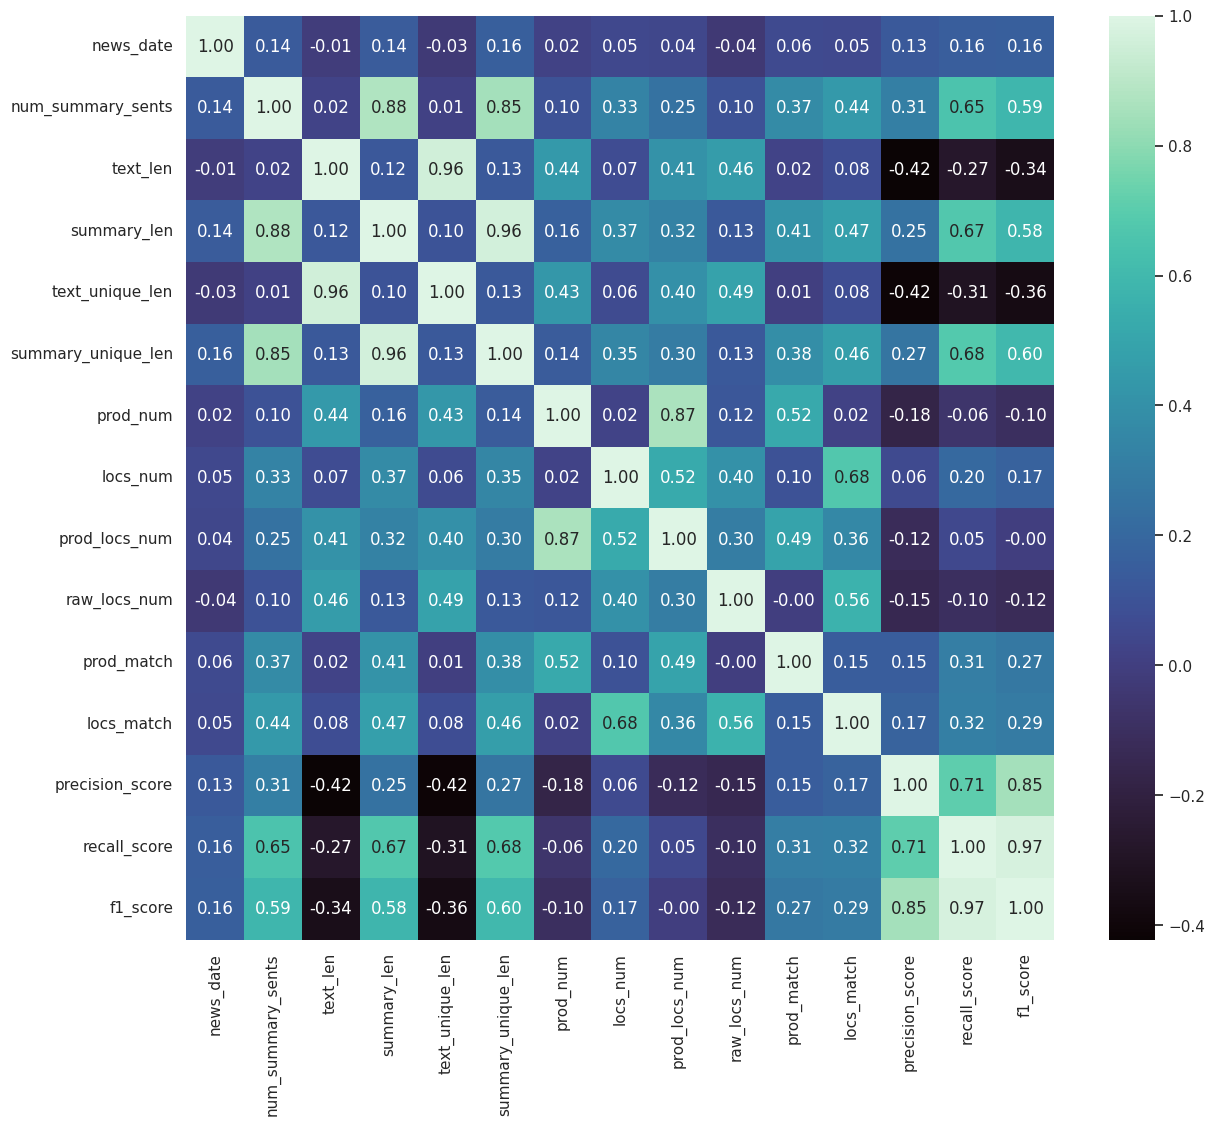

In [44]:
corr_m = df.select_dtypes(include=np.number).corr()
plt.figsize = (10, 8)
sns.heatmap(corr_m, annot=True, cmap="mako", fmt=".2f")

Видна заметная корреляция полноты и данных, связанных с длиной саммари. Т.е. с ростом длины саммари и полнота быдет увеличиваться.
При этом нет никаких линейных зависимостей с такими показателями как количество продуктов, локаций или их матчингом.

In [34]:
df.describe()

,news_date,num_summary_sents,text_len,summary_len,text_unique_len,summary_unique_len,prod_num,locs_num,prod_locs_num,raw_locs_num,prod_match,locs_match,precision_score,recall_score,f1_score
count,26921.000000,26921.000000,26921.000000,26921.000000,26921.000000,26921.000000,26921.000000,26921.000000,26921.000000,26921.000000,26921.000000,26921.000000,26921.000000,26921.000000,26921.000000
mean,2022.717507,2.410609,339.858623,57.885703,179.266298,42.689053,3.805059,2.901452,6.706512,6.040117,1.517626,2.864715,0.855738,0.685404,0.759816
std,0.718071,1.873856,287.230124,43.912526,107.715098,23.953803,3.878470,2.279027,4.547349,4.276298,1.831963,2.275681,0.052763,0.081000,0.065605
min,2020.000000,1.000000,7.000000,5.000000,7.000000,5.000000,1.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.560702,0.454958,0.519550
25%,2022.000000,1.000000,179.000000,27.000000,114.000000,25.000000,1.000000,2.000000,4.000000,3.000000,0.000000,1.000000,0.826724,0.628543,0.714708
50%,2023.000000,2.000000,261.000000,44.000000,156.000000,36.000000,3.000000,2.000000,5.000000,5.000000,1.000000,2.000000,0.859698,0.668003,0.749044
75%,2023.000000,3.000000,405.000000,77.000000,216.000000,56.000000,5.000000,3.000000,8.000000,8.000000,2.000000,4.000000,0.887120,0.726442,0.796844
max,2024.000000,32.000000,5636.000000,517.000000,2274.000000,209.000000,100.000000,53.000000,102.000000,54.000000,37.000000,34.000000,1.000000,1.000000,1.000000


In [35]:
rec_57 = df[df.recall_score <= 0.57]
rec_57.shape

(621, 29)

Посмотрим статистики текстов, которые показали метрику recall сходную случайной и ниже

In [33]:
rec_57.describe()

,news_date,num_summary_sents,text_len,summary_len,text_unique_len,summary_unique_len,prod_num,locs_num,prod_locs_num,raw_locs_num,prod_match,locs_match,precision_score,recall_score,f1_score
count,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000
mean,2022.513688,1.104670,589.246377,20.260870,251.491143,18.668277,4.510467,2.190016,6.700483,6.855072,0.850242,1.942029,0.781612,0.550677,0.645181
std,0.682894,0.417744,529.813018,11.830506,199.546394,9.069771,5.608631,1.014077,5.662310,5.272717,0.958049,1.127310,0.057529,0.018498,0.026129
min,2020.000000,1.000000,75.000000,5.000000,49.000000,5.000000,1.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.587059,0.454958,0.519550
25%,2022.000000,1.000000,295.000000,13.000000,164.000000,13.000000,2.000000,2.000000,4.000000,3.000000,0.000000,1.000000,0.757063,0.542759,0.632348
50%,2023.000000,1.000000,551.000000,17.000000,223.000000,17.000000,3.000000,2.000000,5.000000,6.000000,1.000000,2.000000,0.796598,0.556590,0.650041
75%,2023.000000,1.000000,708.000000,25.000000,275.000000,23.000000,5.000000,2.000000,7.000000,9.000000,1.000000,2.000000,0.818632,0.564620,0.664019
max,2024.000000,5.000000,5337.000000,110.000000,2274.000000,80.000000,60.000000,9.000000,62.000000,52.000000,6.000000,7.000000,0.883107,0.569986,0.690731


Тут тексты с длиной саммари от 5 до 110 символов. При этом основная часть этой подвыборки, 75%, содержит от 5 до 25 слов в саммари. и в этой же части данных 1-5 продуктов, 1-2 локации.

В целом это достаточно логично, что при небольшом количестве слов полнота передачи информации может быть небольшой. С другой стороны - если локаций и продуктов не очень много, то и длина саммари может быть небольшой, поэтому я не совсем понимаю, показательно это или нет.

Посмотрим на самые длинные саммари этой части данных с низкой полнотой.

In [43]:
rec_57[(rec_25['summary_len'] > 50)]

,text,raw_product,product,raw_locations,locations,news_date,url,summary,lang,text_words,...,summary_unique_len,prod_num,locs_num,prod_locs_num,raw_locs_num,prod_match,locs_match,precision_score,recall_score,f1_score
411,https://ria.ru/20221128/lukashenko-1834694302....,"продукты питание, техника","продукты питание, техника","Беларусь, белоруссия, Белоруссия, белорусская,...","Беларусь, Россия",2022,https://ria.ru/20221128/lukashenko-1834694302....,Президент Белоруссии Александр Лукашенко собир...,ru,"['https', ':', '/', '/', 'ria', '.', 'ru', '/'...",...,46,2,2,4,7,0,2,0.695524,0.569651,0.626326
4726,One year of Russia’s war in Ukraine Portraits ...,"gas, oil",oil,"Russia, Russian, Ukraine, Ukrainian, Western","Уганда, Китай, Танзания",2023,https://www.washingtonpost.com/world/2023/05/1...,Uganda's Ministry of Energy said that major Ch...,en,"['one', 'year', 'of', 'russia', '’', 's', 'war...",...,43,2,3,5,5,1,0,0.628879,0.568345,0.597082
5033,https://ria.ru/20230526/sanktsii-1874238714.ht...,"3D, водка, древесина, золото, квантовые компью...","водка, древесина, золото, квантовые компьютеры...","Запад, Киев, российские, россия, Россия, РФ, С...","Япония, Россия",2023,https://ria.ru/20230526/sanktsii-1874238714.html,Япония ввела новый пакет санкций против прокур...,ru,"['https', ':', '/', '/', 'ria', '.', 'ru', '/'...",...,50,13,2,15,8,0,2,0.701643,0.567723,0.627619
5615,https://ria.ru/20230621/astra-1879477107.html ...,"Astra Linux, ОС",ОС,"Африка, Ближний Восток, Индия, российские, рос...","Индия, Африка, Ближний Восток, Латинская Амери...",2023,https://ria.ru/20230621/astra-1879477107.html,"ГК ""Астра"" рассчитывает, что к 2026-2027 годам...",ru,"['https', ':', '/', '/', 'ria', '.', 'ru', '/'...",...,46,2,5,7,5,2,5,0.702315,0.561557,0.624098
7852,https://ria.ru/20230904/tovary-1894117793.html...,"компьютерные, электронные компоненты","CLASSIFIED_BY_TEXT, компьютерные","Британия, Вашингтон, европейские, Запад, Москв...","ОАЭ, США, Великобритания, ЕС, Россия, Турция, ...",2023,https://ria.ru/20230904/tovary-1894117793.html,"США, Великобритания и ЕС будут оказывать давле...",ru,"['https', ':', '/', '/', 'ria', '.', 'ru', '/'...",...,56,2,7,9,11,1,6,0.716338,0.569076,0.634271
13740,La Commission verse des préfinancements REPowe...,"analytics software, Atlantic salmon, combustib...","analytics software, Atlantic salmon, electrici...","Australia, Belgique, Chypre, Croatie, 'espagne...","ЕС, Испания, Великобритания",2024,https://ec.europa.eu/commission/presscorner/de...,The European Commission has opened an in-depth...,en,"['la', 'commission', 'verse', 'des', 'préfinan...",...,54,9,3,12,31,0,4,0.610305,0.552701,0.580077
14393,Германия достигла предела в производстве и пос...,боеприпасы,боеприпасы,"Великобритания, Германии,, Германия, германска...","Германия, Украина, Литва",2024,https://rossaprimavera.ru/news/6fd65975,Новый пакет военной помощи пообещала предостав...,ru,"['германия', 'достигла', 'предела', 'в', 'прои...",...,68,1,3,4,6,0,2,0.642960,0.566891,0.602535
16655,"По словам Ахмеда Абу аль-Гейта, Запад оказывае...",Статья Pro,NaN,"арабские, Бахрейн, Египет, Запад, Лига, Марокк...","Беларусь, Иран, Казахстан, Китай, Европа и Сев...",2022,https://www.rbc.ru/politics/13/06/2022/62a6c85...,"Трасса «Меридиан» компании «Автодор», которая ...",ru,"['по', 'словам', 'ахмеда', 'абу', 'аль-гейта',...",...,51,1,6,7,12,0,0,0.621716,0.567890,0.593585
22138,Дефицит внешнеторгового баланса в Молдове к ма...,"автомобили, Машина, мотоциклы, сальдо, черешня",NaN,"Беларусь, Европа, европейские, Иран, Краснодар...","Молдавия, Азия, Африка, Ближний Восток, Европа...",2022,https://mda.minpromtorg.gov.ru/news/?alias=day...,Миссия Международного валютного фонда (МВФ) во...,ru,"['дефицит', 'внешнеторгового', 'баланса', 'в',...",...,52,5,8,13,15,0,0,0.632604,0.551106,0.589049
22259,Новости Правительства 14–15 июня делегация фин...,"Ald, A. R. A. Almirante Irízar, Ford Fiesta, S...",NaN,"Азия, Американская, Аргентина, аргентинская, Б...","Бельгия, Финл

В длинный предложения с низкой полнотой попали в основном русские тексты. Вероятно, это может быть связано с тем, что английский менее многословный язык. Длины предложений в английском и русском отличаются.

Проверим это, также посмотрим длины саммари по языкам

In [46]:
df.lang.value_counts(normalize=True)

lang
ru    0.725939
en    0.274061
Name: proportion, dtype: float64

In [47]:
rec_57.lang.value_counts(normalize=True)

lang
ru    0.760064
en    0.239936
Name: proportion, dtype: float64

Соотношение языков в этой части 

In [54]:
from scipy import stats

In [53]:
df.lang.value_counts(normalize=True).values

array([0.72593886, 0.27406114])

In [59]:
full = df.lang.value_counts(normalize=True).values
lang57 = rec_57.lang.value_counts(normalize=True).values

In [61]:
stats.ttest_rel(lang57, full)

TtestResult(statistic=1.6266739895886744e-15, pvalue=0.9999999999999989, df=1)

p-value больше  0.05, т.о. язык не влияет на полноту.

Проверим аналогично количество продуктов и локаций для языка в этой части данных.

In [67]:
df.groupby("lang").agg({"prod_num": "mean"})["prod_num"].values

array([5.42477636, 3.19357315])

In [69]:
full_prod = df.groupby("lang").agg({"prod_num": "mean"})["prod_num"].values
lang57_prod = rec_57.groupby("lang").agg({"prod_num": "mean"})["prod_num"].values
full_locs = df.groupby("lang").agg({"locs_num": "mean"})["locs_num"].values
lang57_locs = rec_57.groupby("lang").agg({"locs_num": "mean"})["locs_num"].values
full_raw_locs_num = df.groupby("lang").agg({"raw_locs_num": "mean"})["raw_locs_num"].values
lang57_raw_locs_num = rec_57.groupby("lang").agg({"raw_locs_num": "mean"})["raw_locs_num"].values

In [70]:
stats.ttest_rel(full_prod, lang57_prod)

TtestResult(statistic=-1.6982404591813118, pvalue=0.3387942347143203, df=1)

In [72]:
stats.ttest_rel(full_locs, lang57_locs)

TtestResult(statistic=5.611509545912636, pvalue=0.11227037400273392, df=1)

In [71]:
stats.ttest_rel(full_raw_locs_num, lang57_raw_locs_num)

TtestResult(statistic=-0.5286448612611307, pvalue=0.6904117868157564, df=1)

Статистическая знаимость для разных языков в группировке по продуктам и локациям не обнаружена

Посмотрим новости, лежащие выше 75 перцентиля полноты. Возможно, тут обнаружится какая-то зависимость от сущностей или от длины саммари.

In [75]:
rec_75 = df[df["recall_score"] > df["recall_score"].quantile(0.75)]
rec_75.shape

(6730, 29)

In [76]:
df["recall_score"].quantile(0.75)

0.7264424562454224

In [78]:
rec_75.describe()

,news_date,num_summary_sents,text_len,summary_len,text_unique_len,summary_unique_len,prod_num,locs_num,prod_locs_num,raw_locs_num,prod_match,locs_match,precision_score,recall_score,f1_score
count,6730.000000,6730.00000,6730.000000,6730.000000,6730.000000,6730.000000,6730.000000,6730.000000,6730.00000,6730.000000,6730.000000,6730.000000,6730.000000,6730.000000,6730.000000
mean,2022.872214,4.30000,233.347103,102.603120,132.947400,67.357504,3.474443,3.613967,7.08841,5.472214,2.381575,3.974889,0.906647,0.798009,0.848100
std,0.723068,2.28746,189.877806,51.154458,81.011975,24.334751,3.619479,3.062753,4.89331,4.074746,2.579286,3.074271,0.038739,0.064137,0.048812
min,2020.000000,1.00000,10.000000,11.000000,10.000000,11.000000,1.000000,1.000000,2.00000,1.000000,0.000000,0.000000,0.622279,0.726466,0.675278
25%,2022.000000,3.00000,135.000000,67.000000,87.000000,50.000000,1.000000,2.000000,4.00000,3.000000,1.000000,2.000000,0.882565,0.748305,0.813236
50%,2023.000000,4.00000,188.000000,93.000000,115.000000,64.000000,2.000000,2.000000,6.00000,5.000000,2.000000,3.000000,0.907127,0.777847,0.835307
75%,2023.000000,5.00000,268.000000,126.000000,152.000000,81.000000,4.000000,4.000000,9.00000,7.000000,3.000000,5.000000,0.930848,0.830147,0.872235
max,2024.000000,32.00000,3657.000000,517.000000,1488.000000,209.000000,100.000000,32.000000,102.00000,51.000000,26.000000,31.000000,1.000000,1.000000,1.000000


In [80]:
df.lang.value_counts(normalize=True)

lang
ru    0.725939
en    0.274061
Name: proportion, dtype: float64

In [81]:
rec_75.lang.value_counts(normalize=True)

lang
ru    0.865676
en    0.134324
Name: proportion, dtype: float64

Соотношение языков в этой части  (> 75%)

In [82]:
full = df.lang.value_counts(normalize=True).values
lang75 = rec_75.lang.value_counts(normalize=True).values

In [83]:
stats.ttest_rel(lang75, full)

TtestResult(statistic=2.9794040330840833e-16, pvalue=0.9999999999999998, df=1)

p-value больше  0.05, т.о. язык не влияет на полноту.

Проверим аналогично количество продуктов и локаций для языка в этой части данных.

In [85]:
full_prod = df.groupby("lang").agg({"prod_num": "mean"})["prod_num"].values
lang75_prod = rec_75.groupby("lang").agg({"prod_num": "mean"})["prod_num"].values
full_locs = df.groupby("lang").agg({"locs_num": "mean"})["locs_num"].values
lang75_locs = rec_75.groupby("lang").agg({"locs_num": "mean"})["locs_num"].values
full_raw_locs_num = df.groupby("lang").agg({"raw_locs_num": "mean"})["raw_locs_num"].values
lang75_raw_locs_num = rec_75.groupby("lang").agg({"raw_locs_num": "mean"})["raw_locs_num"].values

In [86]:
stats.ttest_rel(full_prod, lang75_prod)

TtestResult(statistic=0.7630162715535498, pvalue=0.5850642131891524, df=1)

In [87]:
stats.ttest_rel(full_locs, lang75_locs)

TtestResult(statistic=-12.019574045528568, pvalue=0.05284355163103269, df=1)

In [88]:
stats.ttest_rel(full_raw_locs_num, lang75_raw_locs_num)

TtestResult(statistic=2.1143769090889517, pvalue=0.28124365163113507, df=1)

Статистическая знаимость для разных языков в группировке по продуктам и локациям не обнаружена и для высокой полноты. При этом p_value для локаций очень близка к статистически значимому параметру (хотя и не достигает его). Также степени разницы между средними значениями двух выборок невелики.

Смотрим статистическую значимость по языку и длине саммари.

In [91]:
full_summary_len = df.groupby("lang").agg({"summary_len": "mean"})["summary_len"].values
lang75_summary_len = (rec_75.groupby("lang").agg({"summary_len": "mean"})["summary_len"].values)

In [92]:
stats.ttest_rel(full_summary_len, lang75_summary_len)

TtestResult(statistic=-9.32085824470319, pvalue=0.0680402938124193, df=1)

Также не выявлена статистическая значимость.


Смотрим самую высокую полноту.

In [99]:
rec_95 = df[df["recall_score"] >= df["recall_score"].quantile(0.95)]
rec_95.shape

(1347, 29)

In [100]:
df["recall_score"].quantile(0.95)

0.8463029861450195

In [101]:
rec_95.describe()

,news_date,num_summary_sents,text_len,summary_len,text_unique_len,summary_unique_len,prod_num,locs_num,prod_locs_num,raw_locs_num,prod_match,locs_match,precision_score,recall_score,f1_score
count,1347.000000,1347.000000,1347.000000,1347.000000,1347.000000,1347.000000,1347.000000,1347.000000,1347.000000,1347.000000,1347.000000,1347.000000,1347.000000,1347.000000,1347.000000
mean,2022.911656,5.221232,157.708241,124.726058,92.878990,75.025984,3.371938,3.787676,7.159614,4.736451,2.929473,4.234595,0.950762,0.905742,0.927428
std,0.717271,2.939468,136.487818,62.184681,56.793618,26.755345,4.332799,3.209995,5.602661,3.709495,3.149365,3.293457,0.028174,0.043518,0.033657
min,2020.000000,1.000000,32.000000,28.000000,26.000000,25.000000,1.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.674901,0.846303,0.768854
25%,2022.000000,3.000000,101.500000,84.000000,67.000000,57.000000,1.000000,2.000000,4.000000,2.000000,1.000000,2.000000,0.932708,0.868201,0.900899
50%,2023.000000,5.000000,135.000000,110.000000,85.000000,69.000000,2.000000,3.000000,6.000000,4.000000,2.000000,3.000000,0.953360,0.895183,0.920106
75%,2023.000000,6.000000,182.000000,148.500000,108.000000,89.000000,4.000000,5.000000,9.000000,6.000000,3.000000,5.000000,0.971625,0.941946,0.956225
max,2024.000000,32.000000,3657.000000,514.000000,1488.000000,209.000000,100.000000,24.000000,102.000000,51.000000,26.000000,25.000000,1.000000,1.000000,1.000000


In [102]:
rec_95.lang.value_counts(normalize=True)

lang
ru    0.944321
en    0.055679
Name: proportion, dtype: float64

Соотношение языков в этой части  (> 95%)

In [103]:
lang95 = rec_95.lang.value_counts(normalize=True).values
stats.ttest_rel(lang95, full)

TtestResult(statistic=1.2709652856581924e-16, pvalue=1.0, df=1)

In [104]:
lang95_prod = rec_95.groupby("lang").agg({"prod_num": "mean"})["prod_num"].values
lang95_locs = rec_95.groupby("lang").agg({"locs_num": "mean"})["locs_num"].values
lang95_raw_locs_num = rec_95.groupby("lang").agg({"raw_locs_num": "mean"})["raw_locs_num"].values

In [105]:
stats.ttest_rel(full_prod, lang95_prod)

TtestResult(statistic=19.497304036023703, pvalue=0.032623096250881445, df=1)

In [106]:
stats.ttest_rel(full_prod, lang95_locs)

TtestResult(statistic=15.860594724564216, pvalue=0.04008539541250683, df=1)

In [107]:
stats.ttest_rel(full_prod, lang95_raw_locs_num)

TtestResult(statistic=14.595766432068654, pvalue=0.04354868698024343, df=1)

In [110]:
print(f"full_prod: {round(np.mean(full_prod), 4)} +/- {round(np.std(full_prod), 4)}")
print(f"lang95_prod: {round(np.mean(lang95_prod), 4)} +/- {round(np.std(lang95_prod), 4)}")

full_prod: 59.3852 +/- 3.3183
lang95_prod: 3.7867 +/- 0.4667


In [111]:
lang95_summary_len = (
    rec_95.groupby("lang").agg({"summary_len": "mean"})["summary_len"].values
)
stats.ttest_rel(full_summary_len, lang95_summary_len)

TtestResult(statistic=-30.166373302996835, pvalue=0.021095898009771123, df=1)

In [113]:
print(
    f"full_prod: {round(np.mean(full_summary_len), 4)} +/- {round(np.std(full_summary_len), 4)}"
)
print(
    f"lang95_summary_len: {round(np.mean(lang95_summary_len), 4)} +/- {round(np.std(lang95_summary_len), 4)}"
)

full_prod: 59.3852 +/- 3.3183
lang95_summary_len: 125.7207 +/- 1.1193


В саммари, получившими максимально высокий recall выжными оказываются все параметры в разбивке по языкам (относительно полной выборки)